In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import qr
from tensor_factor import TenAls
from deicode.preprocessing import rclr
from deicode.optspace import OptSpace

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
%matplotlib inline 

def plot_pcoa(x, y, samples, md, ax, factor_, colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, x],
           samples.loc[idx, y], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1',fontsize=15)
    ax.set_ylabel('PC2',fontsize=15)
    
    return ax

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [2]:
# generate random noiseless low-rank orthogonal tensor

r =2 # rank is 2
n1 = 10
n2 = 10
n3 = 10
U01 = np.random.rand(n1,r)
U02 = np.random.rand(n2,r)
U03 = np.random.rand(n3,r)
U1, temp = qr(U01)
U2, temp = qr(U02)
U3, temp = qr(U03)
U1=U1[:,0:r]
U2=U2[:,0:r]
U3=U3[:,0:r]
T = np.zeros((n1,n2,n3))
for i in range(n3):
    T[:,:,i] = np.matmul(U1,np.matmul(np.diag(U3[i,:]),U2.T))
# sample entries 
p = 2*(r**0.5*np.log(n1*n2*n3))/np.sqrt(n1*n2*n3)
E = abs(np.ceil(np.random.rand(n1,n2,n3)-1+p))
TE = T*E


In [3]:
# TenAls no noise
L1,L2,L3,s,dist = TenAls(TE,E)
s = np.diag(s)
# test accruacy 
rmse=0
for i3 in range(n3): 
    A1 = U1
    A2 = np.matmul(U2,np.diag(U3[i3,:]))
    B1 = L1
    B2 = np.matmul(L2,np.diag(L3[i3,:]*s.T.flatten()))
    rmse+= np.trace(np.matmul(np.matmul(A1.T,A1),np.matmul(A2.T,A2))) + \
           np.trace(np.matmul(np.matmul(B1.T,B1),np.matmul(B2.T,B2))) + \
           -2*np.trace(np.matmul(np.matmul(B1.T,A1),np.matmul(A2.T,B2)))
rmse

2.6020852139652106e-16

In [4]:
#TenAls some noise
TE_noise = TE+(0.0001/np.sqrt(n1*n2*n3)*np.random.randn(n1,n2,n3)*E)
L1,L2,L3,s,dist = TenAls(TE_noise,E)
s = np.diag(s)
# test accruacy 
rmse=0
for i3 in range(n3): 
    A1 = U1
    A2 = np.matmul(U2,np.diag(U3[i3,:]))
    B1 = L1
    B2 = np.matmul(L2,np.diag(L3[i3,:]*s.T.flatten()))
    rmse+= np.trace(np.matmul(np.matmul(A1.T,A1),np.matmul(A2.T,A2))) + \
           np.trace(np.matmul(np.matmul(B1.T,B1),np.matmul(B2.T,B2))) + \
           -2*np.trace(np.matmul(np.matmul(B1.T,A1),np.matmul(A2.T,B2)))
rmse

9.235888338843257e-10

In [5]:
from skbio.stats.composition import clr
from simulations import build_block_model
from deicode.preprocessing import rclr

In [6]:

## microbe simulations ## 

depth = 2.5e3
overlap_ = 5
rank_ = 2

n1 = 60
n2 = 500
n3 = 100
# run model with fit variables and new variants
TE = []
for i in range(n3):
    _,X_signal = build_block_model(rank_,  depth/(.6*(i+1)), depth/(.6*(i+1)), 
                                 depth, depth
                                 ,n1,n2,overlap=overlap_
                                 ,mapping_on=False)
    TE.append(X_signal)
TE = np.array(TE)

# flatten, transform, and reshape 
TE_clr = rclr().fit_transform(TE.reshape(-1, TE.shape[-1])).reshape(TE.shape)
TE_clr[np.isnan(TE_clr)] = 0 
E = np.zeros(TE_clr.shape)
E[abs(TE_clr)>0] = 1

# Compostional-TenAls
L1,L2,L3,s,dist = TenAls(TE_clr,E)


In [15]:
TE.reshape(-1, TE.shape[-1]).shape

(50000, 60)

In [12]:
TE_clr.shape

(100, 500, 60)

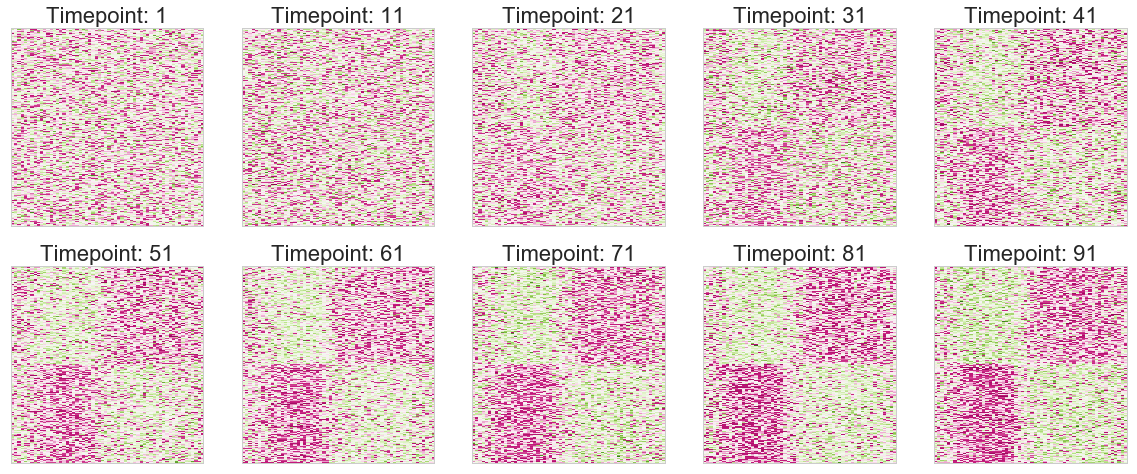

In [7]:

fig,axn = plt.subplots(2,5,figsize=(20,8))
for i,ax in zip(np.arange(0,100,10),axn.flat):
    ax.imshow(clr(TE[i,:,:]+1),aspect='auto',
              norm=MidpointNormalize(midpoint=0.), cmap='PiYG')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Timepoint: '+str(i+1),fontsize=22)

plt.show()



In [8]:

# t=0
t_zero_rclr = rclr().fit_transform(TE[0,:,:].T)
opt_zero = OptSpace().fit(t_zero_rclr)
U_zero = pd.DataFrame(opt_zero.sample_weights)
# t=29 (final)
t_end_rclr = rclr().fit_transform(TE[99,:,:].T)
opt_end = OptSpace().fit(t_end_rclr)
U_end = pd.DataFrame(opt_end.sample_weights)
# map
mapping = pd.DataFrame(TE.shape[-1]//2*[1]+TE.shape[-1]//2*[2],columns=['groups'])


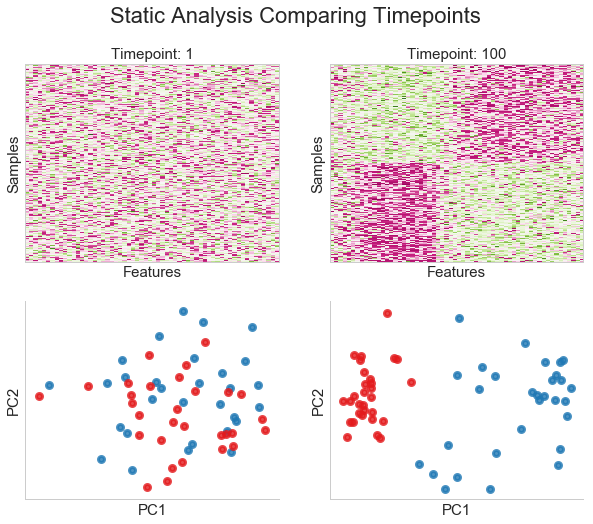

In [9]:

fig,axn = plt.subplots(2,2,figsize=(10,8))

for i,j in zip([0,99],[0,1]):
    axn[0,j].imshow(clr(TE[i,:,:]+1),aspect='auto',
              norm=MidpointNormalize(midpoint=0.), cmap='PiYG')
    axn[0,j].set_xticks([])
    axn[0,j].set_yticks([])
    axn[0,j].set_xlabel('Features',fontsize=15)
    axn[0,j].set_ylabel('Samples',fontsize=15)
    axn[0,j].set_title('Timepoint: '+str(i+1),fontsize=15)

for U_,j in zip([U_zero,U_end],[0,1]):
    _ = plot_pcoa(1, 0, U_, mapping, axn[1,j], 'groups')

plt.suptitle('Static Analysis Comparing Timepoints',fontsize=22)   
    
plt.show()


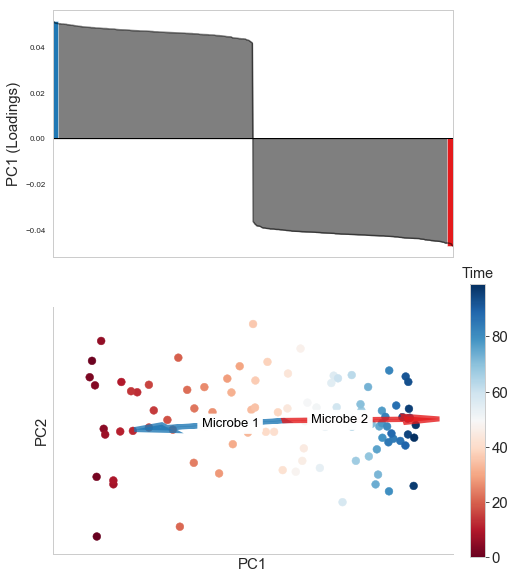

In [10]:

fig,(ax1,ax) = plt.subplots(2,1,figsize=(8,10), facecolor='white')

## loadings ##
L2df = pd.DataFrame(L2).sort_values(0,ascending=False).reset_index(drop=True)

colormap_ = {L2df.index[0]:'#1f78b4',
            L2df.index[-1]:'#e41a1c'}
L2df_bar = L2df.copy()
L2df_bar.loc[list(set(L2df_bar.index) - set(colormap_.keys()))]=0
for ind_ in L2df_bar.index:
    if ind_ not in colormap_.keys():
        colormap_[ind_]='#3f4244'  
L2df_bar[0].plot(kind='bar',color=[colormap_[x] for x in L2df_bar.index], 
             width=14,ax=ax1)
L2df[0].plot(kind='area',color='black',stacked=False, 
             ax=ax1, fontsize=8)
ax1.set_xticks([])
ax1.set_ylabel('PC1 (Loadings)',fontsize=15)
ax1.axhline(0,c='black',lw=1,ls='-')
ax1.set_xlim(min(L2df.index),max(L2df.index))
ax1.grid()

## biplot ##

#Call the function. Use only the 2 PCs.
sc = ax.scatter(L1[:,0],L1[:,1], 
            c = np.array(range(L1.shape[0])), 
            cmap='RdBu',s=60)
#cbar = fig.colorbar(sc, ax=ax)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.12, 0.025, 0.38])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15) 
cbar.ax.set_title('Time')

# biplot
vectors = L2[[0,-1],:]
for i,c_ in zip(range(vectors.shape[0]),['#1f78b4','#e41a1c']):
    ax.arrow(np.mean(L1[:,0]), np.mean(L1[:,1]), 
              vectors[i,0]*1.2, vectors[i,1]*1.2,
              head_width=0.016, head_length=0.016, 
             fc=c_, ec=c_, lw=5, alpha =.8)
    
    props = dict(boxstyle='round', facecolor='white', alpha=.99)
    ax.text((np.mean(L1[:,0])+vectors[i,0]/1.8), 
             (np.mean(L1[:,1])+vectors[i,1]/1.8), 
             "Microbe "+str(i+1), color = 'k', 
             ha = 'center', va = 'center', bbox=props, fontsize=13)
    
ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)

plt.show()



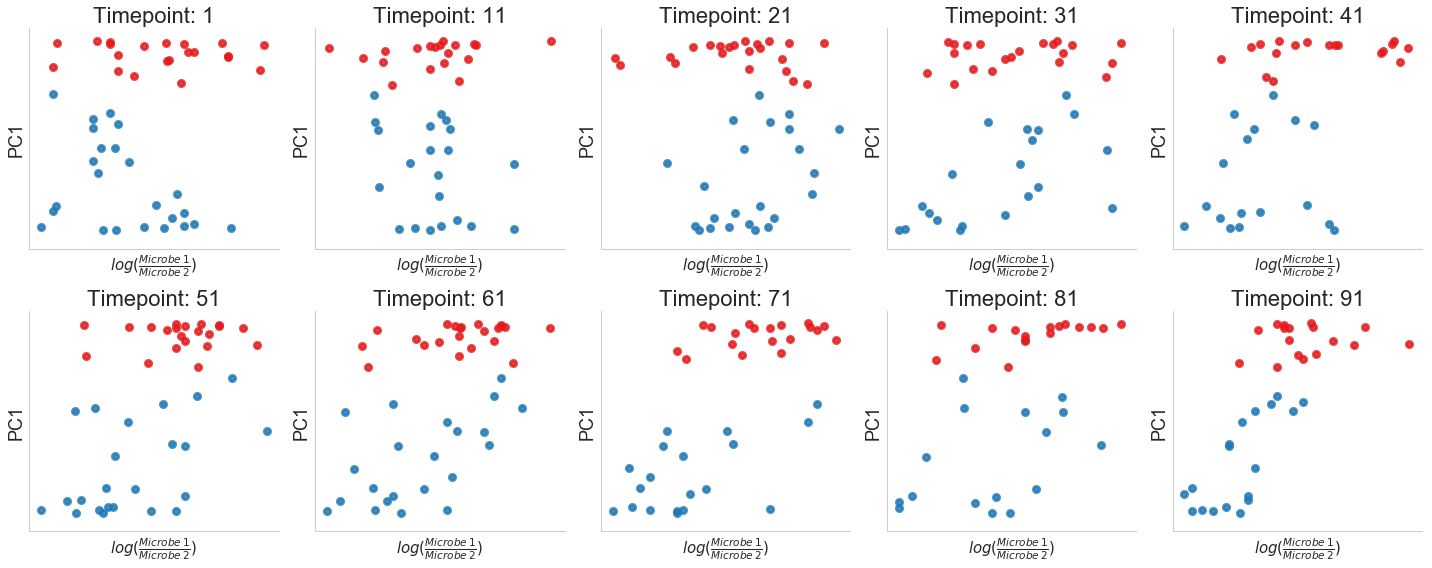

In [11]:
fig,axn = plt.subplots(2,5,figsize=(20,8))
for i,ax in zip(np.arange(0,100,10),axn.flat):
    
    mapping = pd.DataFrame(TE.shape[-1]//2*[1]+TE.shape[-1]//2*[2],columns=['groups'])
    L3df = pd.DataFrame(L3)
    loads_ = pd.DataFrame(L2).sort_values(0,ascending=False)
    ratio_ = (np.log(TE[i,loads_.index[0],:]) - np.log(TE[i,loads_.index[-1],:]))
    L3df['ratio'] = ratio_
    L3df = L3df[np.isfinite(L3df['ratio'])]
    _ = plot_pcoa('ratio', 0, L3df, mapping, ax, 'groups')
    ax.set_ylabel('PC1',fontsize=18)
    ax.set_xlabel('$log(\\frac{Microbe\,1}{Microbe\,2})$',fontsize=15)
    ax.set_title('Timepoint: '+str(i+1),fontsize=22)
plt.tight_layout()
plt.show()


